# Data Augmentation with Hyperparameter Tuning

In [1]:
# basics
import os
import utils
import numpy as np
from tqdm.notebook import tqdm 


# torch
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import lightning as L


# custom modules
from data_acquisition import DataHandler
from data_preparation import apply_preprocessing_pipeline


# Configure logging for the pipeline
logger = utils.setup_logger(level='ERROR')

In [2]:
import numpy as np
from utilities.dataset_jlb import CityDataset
cities = ["Aachen", "Wien", 'London', 'CapeTown', 'Hamburg', 'Johannesburg', 'Montreal', 'Paris', 'Seoul', 'Singapore', 'Sydney']

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
import lightning as L
from typing import Any
from torch.utils.data import DataLoader, Dataset
from lightning import seed_everything
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from utilities.Lightning_utils import LitModule
from utilities.Lightning_utils import ConvNetSimple

from lightning.pytorch.tuner.tuning import Tuner

# model
# convmodel = LitModule(ConvNetSimple())

# trainer
def get_trainer(dirname):
    trainer = L.Trainer(
        default_root_dir=f"models/augmentation/{dirname}",
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                mode="min",
                patience=5,
            ),
            ModelCheckpoint(
                dirpath=f"models/augmentation/{dirname}",
                monitor="val_loss",
                mode="min",
                save_top_k=1,
                filename="best_model"
            )
        ],
        # val_check_interval=1,
        fast_dev_run=False,
        num_sanity_val_steps=2,
        max_epochs=100,
        log_every_n_steps=20,
    )
    return trainer

#### Here we import the Data Augmentation Transformation

In [9]:
from utilities.transformations import (ColorJitterCustom,
                                       random_rotation,
                                       random_horizontal_flip,
                                       random_vertical_flip
                                       )


from torchvision.transforms import Compose, Lambda, RandomHorizontalFlip, RandomVerticalFlip, RandomChoice

# transforms_train = Compose([
#     random_rotation,
#     random_horizontal_flip,
#     random_vertical_flip,
#     ColorJitterCustom(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
# ])



# Compose the transformations
custom_transforms1 = Compose([
    random_rotation,
    random_horizontal_flip,
    random_vertical_flip,
    ColorJitterCustom(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

custom_transforms2 = Compose([
    random_rotation,
    random_horizontal_flip,
    random_vertical_flip
])

custom_transforms3 = Compose([
    ColorJitterCustom(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

def no_op(x):
    return x
custom_transforms4 = Compose([
    RandomChoice([random_rotation, random_horizontal_flip, random_vertical_flip, no_op]),
    RandomChoice([random_rotation, random_horizontal_flip, random_vertical_flip, no_op]),
    ColorJitterCustom(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# transformations_list = [custom_transforms1, custom_transforms2, custom_transforms3]
transformations_list = [custom_transforms3]
transformations_list = [custom_transforms4]

In [10]:
torch.set_float32_matmul_precision('high') # for tensor cores
# from data_acquisition import DataHandler

# datahandler = DataHandler(logger, path_to_data_directory="data")


# load images and mask for all specified cites

# import os
# images = []
# dense_masks=[]
# boundary_masks=[]

# for city in tqdm(cities):
#     buildings = None
#     if not os.path.exists(os.path.join(datahandler.path_to_data_directory,city,'building_mask_dense.tif')):
#         print("loading local buildings")
#         buildings = datahandler.get_buildings(city)
#     images.append(datahandler.get_satellite_image(city).transpose(2, 0, 1))
#     dense_masks.append(datahandler.get_building_mask(city, all_touched=True, loaded_buildings=buildings))
#     boundary_masks.append(datahandler.get_boundaries_mask(city))

# print(f"Data len: {len(images)}, {len(dense_masks)}, {len(boundary_masks)}")

dataset = CityDataset("/home/jlb/Projects/architecture-of-ml-systems/data",
                      patch_size=32,
                      min_labels=0.1,
                      cities=cities,
                      train=True,
                    #   images=images,
                    #   buildings_mask=dense_masks,
                    #   boundaries_mask=boundary_masks,
                      )

train_ds, val_ds = dataset.train_val_split(val_size=0.1, show_summary=False)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=20)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=20)

dataset_test = CityDataset("/home/jlb/Projects/architecture-of-ml-systems/data",
                        data_name="openEO.tif",
                        labels_name="building_mask_dense.tif",
                        cities=["BerlinTest"],
                        train=False)
test_dl = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=20)

Loading data from cities:
['Singapore', 'Johannesburg', 'Wien', 'London', 'Montreal', 'Seoul', 'Aachen', 'CapeTown', 'Hamburg', 'Paris', 'Sydney']


Loading Images:   0%|          | 0/11 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/11 [00:00<?, ?it/s]

Creating Patches from Images: 0it [00:00, ?it/s]

Loading data from cities:
['BerlinTest']


Loading Images:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
for idx, transforms in enumerate(transformations_list):
    idx = 4
    # dataset.transform = transforms
    dataset.transform = None
    train_ds, val_ds = dataset.train_val_split(val_size=0.1, show_summary=False)
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=20)
    val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=20)
    model = LitModule(ConvNetSimple(6), learning_rate=0.001, optimizer="adam")
    trainer = get_trainer(f'convSimple/_{idx}_transformation')
    seed_everything(49)
    trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    best_model = LitModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    trainer.test(model=model, dataloaders=test_dl)   


/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49
Missing logger folder: models/augmentation/convSimple/_4_transformation/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/archit

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3676532804965973
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [13]:
prediction = trainer.predict(model=model, dataloaders=test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [14]:
# sample = train_ds[0]
# from utilities.plot_utils import plot_band_with_mask
# print(sample.keys())
# plot_band_with_mask(sample["data"][[0,1,2]].transpose(1,2,0), sample["labels"].squeeze())


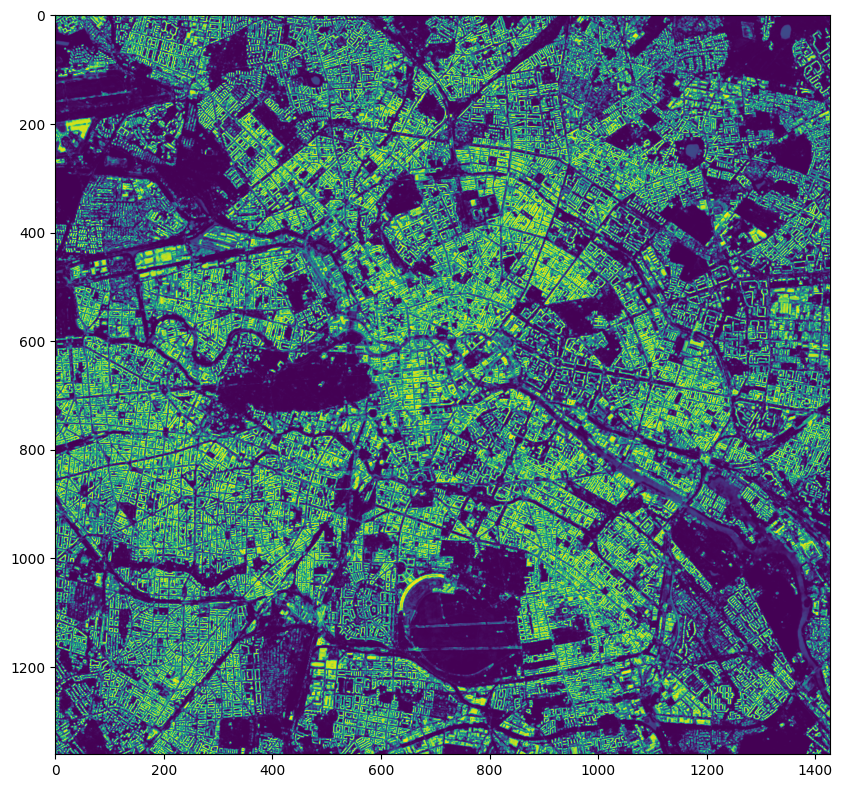

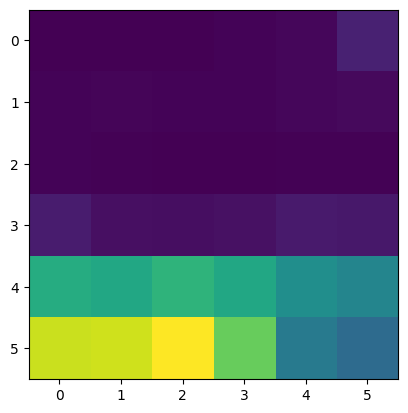

[[0.00104717 0.00247654 0.00328489 0.00612815 0.01205166 0.05924024]
 [0.00742793 0.00861945 0.00735277 0.00812495 0.01230376 0.01771095]
 [0.00660157 0.00390861 0.00321195 0.00305832 0.00495311 0.00590915]
 [0.04844616 0.02750699 0.02526441 0.0284602  0.04686645 0.04252786]
 [0.3953808  0.3826323  0.41608173 0.3829637  0.3154787  0.2909512 ]
 [0.5880818  0.59317756 0.6389239  0.49067092 0.2632187  0.22392303]]


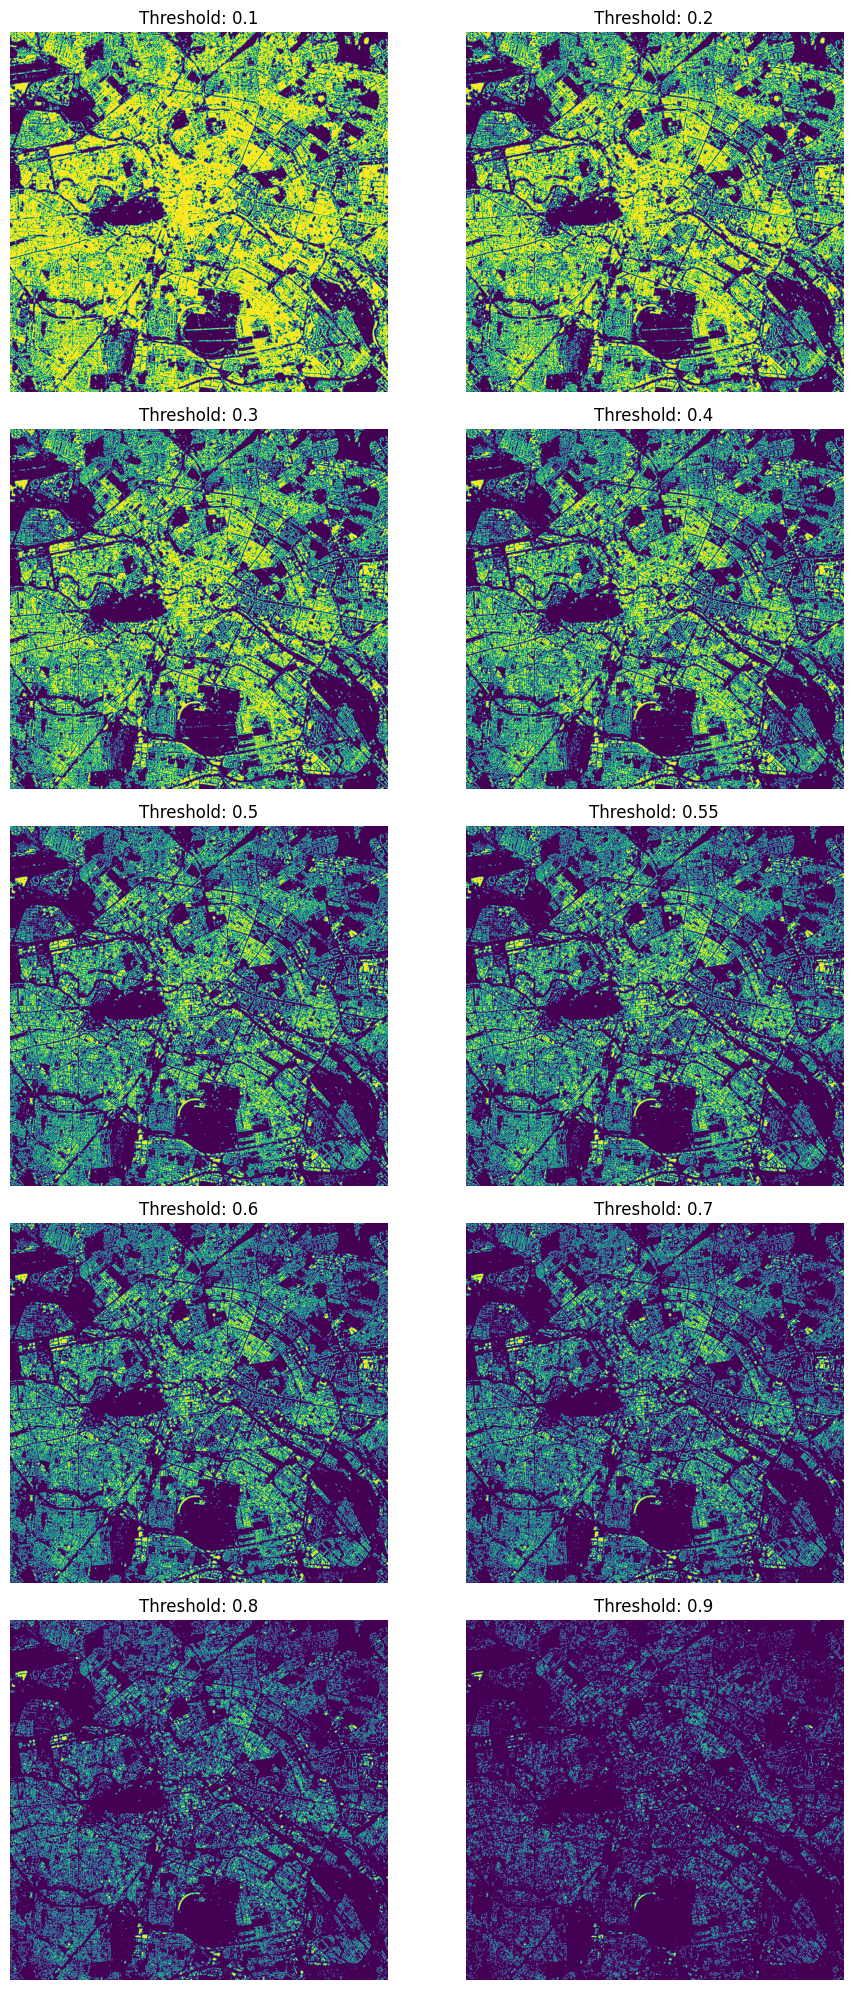

In [15]:
output = prediction[0].detach().numpy()
output = output.squeeze()
from utilities.plot_utils import (
    plot_prediction_with_thresholds,
    plot_random_patch,
    plot_output
)

plot_output(output)
plot_random_patch(output, patch_len=6)
plot_prediction_with_thresholds(output)

In [ ]:
# model_stats = {}
# torch.set_float32_matmul_precision('high') # for tensor cores
# test_dl = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=20)
# for chs in grid:
#     print(chs)
#     # load the data
#     dataset = CityDataset("/home/jlb/Projects/architecture-of-ml-systems/data",
#                       patch_size=32,
#                       data_name="openEO.tif",
#                       labels_name="building_mask_dense.tif",
#                       image_bands=chs,
#                       transform=transforms_train, # <--- augmentation
#                       min_labels=0.1,
#                       cities=cities,
#                       train=True,)
#     train_ds, val_ds = dataset.train_val_split(val_size=0.1, show_summary=False)
#     train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=20)
#     val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=20)

#     dataset_test = CityDataset("/home/jlb/Projects/architecture-of-ml-systems/data",
#                             data_name="openEO.tif",
#                             labels_name="building_mask_dense.tif",
#                             image_bands=chs,
#                             cities=["BerlinTest"],
#                             train=False)
#     test_dl = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=20)


#     for optim in optimizers:
#         print(chs, optim)
#         # create the model
#         model = LitModule(ConvNetSimple(len(chs)), learning_rate=0.001, optimizer=optim)
#         # create the trainer
#         trainer = get_trainer(f'convSimple/{str(chs).replace(", ", "_").replace("[", "_").replace("]", "_")}{optim}')
#         # tuner lr
#         seed_everything(49)
#         tuner = Tuner(trainer=trainer)
#         tuner.lr_find(model, train_dl, val_dl, min_lr=1e-5, max_lr=0.03, num_training=5000)

#         # train the model
#         trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
#         model_stats[f"{str(chs)}_{optim}"] = dict(
#             best_model=trainer.checkpoint_callback.best_model_path,
#         )
#         # test the model
#         best_model = LitModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
#         trainer.test(model=model, dataloaders=test_dl)   


In [ ]:
# dataset.transform = random_rotation

In [ ]:
# dataset[0]

(6, 32, 32)
(1, 32, 32)
torch.Size([6, 32, 32])
torch.Size([1, 32, 32])


{'data': tensor([[[ 987,  843,  928,  ..., 2022, 2387, 2334],
          [1160, 1007,  613,  ..., 2407, 2514, 2380],
          [1004, 1091,  576,  ..., 2338, 2390, 2072],
          ...,
          [ 544,  506,  503,  ...,  336,  222,  228],
          [ 550,  585,  656,  ...,  380,  242,  206],
          [ 550,  755,  890,  ...,  386,  315,  226]],
 
         [[ 981,  876,  887,  ..., 2040, 2363, 2307],
          [1066, 1003,  650,  ..., 2362, 2440, 2289],
          [1016, 1078,  611,  ..., 2292, 2319, 1980],
          ...,
          [ 621,  562,  538,  ...,  604,  527,  509],
          [ 635,  557,  652,  ...,  629,  460,  465],
          [ 671,  724,  833,  ...,  637,  516,  420]],
 
         [[ 643,  535,  681,  ..., 1926, 2291, 2212],
          [ 822,  726,  437,  ..., 2343, 2409, 2216],
          [ 717,  849,  412,  ..., 2213, 2285, 1999],
          ...,
          [ 422,  397,  435,  ...,  287,  224,  250],
          [ 419,  471,  513,  ...,  331,  201,  232],
          [ 399,  564, 

In [ ]:
sample = next(iter(train_dl))

(6, 32, 32)(6, 32, 32)(6, 32, 32)(6, 32, 32)

(6, 32, 32)

(1, 32, 32)(1, 32, 32)
(6, 32, 32)(1, 32, 32)(1, 32, 32)
(1, 32, 32)




torch.Size([6, 32, 32])torch.Size([6, 32, 32])(1, 32, 32)torch.Size([6, 32, 32])torch.Size([6, 32, 32])
torch.Size([6, 32, 32])


(6, 32, 32)
(6, 32, 32)(6, 32, 32)torch.Size([1, 32, 32])(6, 32, 32)torch.Size([6, 32, 32])torch.Size([1, 32, 32])torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
(6, 32, 32)




(6, 32, 32)(1, 32, 32)

(6, 32, 32)(1, 32, 32)
(6, 32, 32)torch.Size([1, 32, 32])(1, 32, 32)
(1, 32, 32)

(1, 32, 32)(6, 32, 32)(6, 32, 32)


(6, 32, 32)(6, 32, 32)(6, 32, 32)
(6, 32, 32)
torch.Size([1, 32, 32])
(1, 32, 32)(6, 32, 32)
(1, 32, 32)

(1, 32, 32)
(6, 32, 32)
torch.Size([6, 32, 32])



torch.Size([6, 32, 32])
torch.Size([6, 32, 32])
torch.Size([6, 32, 32])(6, 32, 32)(1, 32, 32)(1, 32, 32)(1, 32, 32)

(1, 32, 32)

torch.Size([6, 32, 32])(1, 32, 32)(1, 32, 32)(1, 32, 32)(6, 32, 32)


torch.Size([1, 32, 32])torch.Size([1, 32, 32])


torch.Size([

In [ ]:
sample["data"].shape, sample["labels"].shape

(torch.Size([32, 6, 32, 32]), torch.Size([32, 1, 32, 32]))

In [ ]:
from utilities.transformations import random_rotation

random_rotation(sample)

{'data': tensor([[[[ 628,  465,  355,  ..., 1298, 1356, 1440],
           [ 607,  438,  361,  ..., 3476, 3324, 3876],
           [1061,  804,  445,  ..., 5180, 5204, 5148],
           ...,
           [ 604,  885, 1011,  ..., 4952, 3272, 3860],
           [ 500,  782,  934,  ..., 5668, 5192, 5020],
           [ 464,  568,  838,  ..., 5240, 5492, 4484]],
 
          [[ 546,  405,  309,  ..., 1094,  938, 1312],
           [ 603,  397,  320,  ..., 3620, 3608, 3640],
           [1026,  767,  465,  ..., 4916, 5068, 5372],
           ...,
           [ 578,  804,  900,  ..., 4872, 3050, 3520],
           [ 475,  708,  836,  ..., 5612, 5228, 5216],
           [ 484,  522,  780,  ..., 5192, 5380, 4536]],
 
          [[ 329,  234,  138,  ...,  924, 1090, 1324],
           [ 339,  193,  168,  ..., 3480, 3556, 4008],
           [ 723,  554,  234,  ..., 5196, 5380, 5412],
           ...,
           [ 374,  662,  668,  ..., 4912, 3096, 3796],
           [ 244,  538,  732,  ..., 5748, 5348, 5172],
   

UNET

In [ ]:
model_stats = {}
from utilities.unet import UNet

torch.set_float32_matmul_precision('high') # for tensor cores
test_dl = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=20)
for chs in grid:
    print(chs)
    # load the data
    dataset = CityDataset("/home/jlb/Projects/architecture-of-ml-systems/data",
                      patch_size=32,
                      data_name="openEO.tif",
                      labels_name="building_mask_dense.tif",
                      transform=transforms_train, # <--- augmentation
                      image_bands=chs,
                      min_labels=0.1,
                      cities=cities,
                      train=True,)
    train_ds, val_ds = dataset.train_val_split(val_size=0.1, show_summary=False)
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=20)
    val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=20)

    dataset_test = CityDataset("/home/jlb/Projects/architecture-of-ml-systems/data",
                            data_name="openEO.tif",
                            labels_name="building_mask_dense.tif",
                            image_bands=chs,
                            cities=["BerlinTest"],
                            train=False)
    test_dl = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=20)


    for optim in optimizers:
        print(chs, optim)
        # create the model

        # model
        unet = UNet(n_channels=len(dataset.get_image_bands()), n_classes=1, bilinear=True)
        # UNet implementation uses the BCEWithLogitsLoss, lr of 1e-5 default
        model = LitModule(unet, learning_rate=1e-4, loss=nn.BCEWithLogitsLoss())


        # create the trainer
        trainer = get_trainer(f'unet/{str(chs).replace(", ", "_").replace("[", "_").replace("]", "_")}{optim}')
        
        
        # tuner lr
        seed_everything(49)
        tuner = Tuner(trainer=trainer)
        tuner.lr_find(model, train_dl, val_dl, min_lr=1e-5, max_lr=0.03, num_training=5000)

        # train the model
        trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
        model_stats[f"{str(chs)}_{optim}"] = dict(
            best_model=trainer.checkpoint_callback.best_model_path,
        )
        # test the model
        best_model = LitModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        trainer.test(model=model, dataloaders=test_dl)   


[2, 4, 5, 6]
Loading data from cities:
['Singapore', 'Johannesburg', 'London', 'Montreal', 'Seoul', 'Aachen', 'CapeTown', 'Hamburg', 'Paris', 'Sydney']


Loading Images:   0%|          | 0/10 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/10 [00:00<?, ?it/s]

Creating Patches from Images: 0it [00:00, ?it/s]

Loading data from cities:
['BerlinTest']


Loading Images:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/1 [00:00<?, ?it/s]

/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49
Missing logger folder: models/augmentation/unet/_2_4_5_6_sgd/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-m

[2, 4, 5, 6] sgd


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.0046819753582239935
Restoring states from the checkpoint path at models/augmentation/unet/_2_4_5_6_sgd/.lr_find_def26e80-627f-445c-8be1-7f08f69ad880.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_2_4_5_6_sgd/.lr_find_def26e80-627f-445c-8be1-7f08f69ad880.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.054    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         0.336426705121994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49


[2, 4, 5, 6] adamW


Missing logger folder: models/augmentation/unet/_2_4_5_6_adamW/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_2_4_5_6_adamW exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.0010765387360997625
Restoring states from the checkpoint path at models/augmentation/unet/_2_4_5_6_adamW/.lr_find_c84fd079-5126-44cf-bde8-5e547ccee907.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_2_4_5_6_adamW/.lr_find_c84fd079-5126-44cf-bde8-5e547ccee907.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.054    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3629045784473419
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49
Missing logger folder: models/augmentation/unet/_2_4_5_6_adam/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_2_4_5_6_adam exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[2, 4, 5, 6] adam


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.008069996919565841
Restoring states from the checkpoint path at models/augmentation/unet/_2_4_5_6_adam/.lr_find_de096b97-b6bc-49d6-be8d-afb671060726.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_2_4_5_6_adam/.lr_find_de096b97-b6bc-49d6-be8d-afb671060726.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.054    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.4151632487773895
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[1, 2, 3, 4, 5, 6]
Loading data from cities:
['Singapore', 'Johannesburg', 'London', 'Montreal', 'Seoul', 'Aachen', 'CapeTown', 'Hamburg', 'Paris', 'Sydney']


Loading Images:   0%|          | 0/10 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/10 [00:00<?, ?it/s]

Creating Patches from Images: 0it [00:00, ?it/s]

Loading data from cities:
['BerlinTest']


Loading Images:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/1 [00:00<?, ?it/s]

/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49


[1, 2, 3, 4, 5, 6] sgd


Missing logger folder: models/augmentation/unet/_1_2_3_4_5_6_sgd/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_1_2_3_4_5_6_sgd exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.0005338679376498072
Restoring states from the checkpoint path at models/augmentation/unet/_1_2_3_4_5_6_sgd/.lr_find_b5cfb18e-d12a-48a6-aab0-018a921f7301.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_1_2_3_4_5_6_sgd/.lr_find_b5cfb18e-d12a-48a6-aab0-018a921f7301.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.059    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.31925421953201294
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49


[1, 2, 3, 4, 5, 6] adamW


Missing logger folder: models/augmentation/unet/_1_2_3_4_5_6_adamW/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_1_2_3_4_5_6_adamW exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.0010765387360997625
Restoring states from the checkpoint path at models/augmentation/unet/_1_2_3_4_5_6_adamW/.lr_find_e74cf14a-2e40-4921-a96b-9e03346f2cf3.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_1_2_3_4_5_6_adamW/.lr_find_e74cf14a-2e40-4921-a96b-9e03346f2cf3.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.059    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.34835347533226013
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49


[1, 2, 3, 4, 5, 6] adam


Missing logger folder: models/augmentation/unet/_1_2_3_4_5_6_adam/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_1_2_3_4_5_6_adam exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.003122387417252712
Restoring states from the checkpoint path at models/augmentation/unet/_1_2_3_4_5_6_adam/.lr_find_38d4a5da-c676-4d09-b102-6d36356dda77.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_1_2_3_4_5_6_adam/.lr_find_38d4a5da-c676-4d09-b102-6d36356dda77.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.059    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3087840676307678
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[1, 2, 3, 4]
Loading data from cities:
['Singapore', 'Johannesburg', 'London', 'Montreal', 'Seoul', 'Aachen', 'CapeTown', 'Hamburg', 'Paris', 'Sydney']


Loading Images:   0%|          | 0/10 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/10 [00:00<?, ?it/s]

Creating Patches from Images: 0it [00:00, ?it/s]

Loading data from cities:
['BerlinTest']


Loading Images:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/1 [00:00<?, ?it/s]

/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49


[1, 2, 3, 4] sgd


Missing logger folder: models/augmentation/unet/_1_2_3_4_sgd/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_1_2_3_4_sgd exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.00048186644747851085
Restoring states from the checkpoint path at models/augmentation/unet/_1_2_3_4_sgd/.lr_find_3af1c4a8-0b71-40d0-9427-f98864365694.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_1_2_3_4_sgd/.lr_find_3af1c4a8-0b71-40d0-9427-f98864365694.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.054    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3291228711605072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49


[1, 2, 3, 4] adamW


Missing logger folder: models/augmentation/unet/_1_2_3_4_adamW/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_1_2_3_4_adamW exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.004491052098192215
Restoring states from the checkpoint path at models/augmentation/unet/_1_2_3_4_adamW/.lr_find_ab05e3f1-b38f-4457-9674-d14df41ad7f0.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_1_2_3_4_adamW/.lr_find_ab05e3f1-b38f-4457-9674-d14df41ad7f0.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.054    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.39447176456451416
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49
Missing logger folder: models/augmentation/unet/_1_2_3_4_adam/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_1_2_3_4_adam exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[1, 2, 3, 4] adam


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.024994410031336387
Restoring states from the checkpoint path at models/augmentation/unet/_1_2_3_4_adam/.lr_find_bf170c1d-2e26-4780-b845-d38f476f98cd.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_1_2_3_4_adam/.lr_find_bf170c1d-2e26-4780-b845-d38f476f98cd.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.054    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.5240035057067871
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[3, 4, 5, 6]
Loading data from cities:
['Singapore', 'Johannesburg', 'London', 'Montreal', 'Seoul', 'Aachen', 'CapeTown', 'Hamburg', 'Paris', 'Sydney']


Loading Images:   0%|          | 0/10 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/10 [00:00<?, ?it/s]

Creating Patches from Images: 0it [00:00, ?it/s]

Loading data from cities:
['BerlinTest']


Loading Images:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/1 [00:00<?, ?it/s]

/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49
Missing logger folder: models/augmentation/unet/_3_4_5_6_sgd/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-m

[3, 4, 5, 6] sgd


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.0012797804758845315
Restoring states from the checkpoint path at models/augmentation/unet/_3_4_5_6_sgd/.lr_find_381d32b8-cd2f-47d2-9f92-907360a9e090.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_3_4_5_6_sgd/.lr_find_381d32b8-cd2f-47d2-9f92-907360a9e090.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.054    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.34467247128486633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49
Missing logger folder: models/augmentation/unet/_3_4_5_6_adamW/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_3_4_5_6_adamW exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[3, 4, 5, 6] adamW


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.0046819753582239935
Restoring states from the checkpoint path at models/augmentation/unet/_3_4_5_6_adamW/.lr_find_3496f6d7-43e6-4022-8c99-31149463c045.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_3_4_5_6_adamW/.lr_find_3496f6d7-43e6-4022-8c99-31149463c045.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.054    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3518865406513214
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49
Missing logger folder: models/augmentation/unet/_3_4_5_6_adam/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_3_4_5_6_adam exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[3, 4, 5, 6] adam


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.004491052098192215
Restoring states from the checkpoint path at models/augmentation/unet/_3_4_5_6_adam/.lr_find_6a3bc814-e4cf-4b9e-8cb7-7da153eceae3.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_3_4_5_6_adam/.lr_find_6a3bc814-e4cf-4b9e-8cb7-7da153eceae3.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.054    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.32123425602912903
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[1, 4, 5]
Loading data from cities:
['Singapore', 'Johannesburg', 'London', 'Montreal', 'Seoul', 'Aachen', 'CapeTown', 'Hamburg', 'Paris', 'Sydney']


Loading Images:   0%|          | 0/10 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/10 [00:00<?, ?it/s]

Creating Patches from Images: 0it [00:00, ?it/s]

Loading data from cities:
['BerlinTest']


Loading Images:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/1 [00:00<?, ?it/s]

[1, 4, 5] sgd


/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49
Missing logger folder: models/augmentation/unet/_1_4_5_sgd/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-

Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.0010991834392880858
Restoring states from the checkpoint path at models/augmentation/unet/_1_4_5_sgd/.lr_find_8511844b-ac9e-483a-aa21-d08370403521.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_1_4_5_sgd/.lr_find_8511844b-ac9e-483a-aa21-d08370403521.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3877433240413666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49
Missing logger folder: models/augmentation/unet/_1_4_5_adamW/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_1_4_5_adamW exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[1, 4, 5] adamW


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.0012797804758845315
Restoring states from the checkpoint path at models/augmentation/unet/_1_4_5_adamW/.lr_find_2d8c6ab3-36e6-437c-91b8-7974b5639e63.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_1_4_5_adamW/.lr_find_2d8c6ab3-36e6-437c-91b8-7974b5639e63.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.34596654772758484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 49
Missing logger folder: models/augmentation/unet/_1_4_5_adam/lightning_logs
/home/jlb/Projects/architecture-of-ml-systems/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jlb/Projects/architecture-of-ml-systems/models/augmentation/unet/_1_4_5_adam exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[1, 4, 5] adam


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 0.0010765387360997625
Restoring states from the checkpoint path at models/augmentation/unet/_1_4_5_adam/.lr_find_81935955-cf80-4975-b4f1-53ebb828cf41.ckpt
Restored all states from the checkpoint at models/augmentation/unet/_1_4_5_adam/.lr_find_81935955-cf80-4975-b4f1-53ebb828cf41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UNet              | 17.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.33227038383483887
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
import numpy as np
np.array([[1,2,3]]).shape

(1, 3)